In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
import os
os.chdir(os.path.abspath("../src"))

In [4]:
import duckdb as ddb, ibis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import math

## Constants

In [7]:
database_folder_path = '../data/duckdb'
ddb_file_name = 'intermediate_files.db'

## Functions

In [8]:
def show_values_on_bars(axs, h_v="v", space=0.8, use_percent=False, text_rotation=0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width / 2
                _y = p.get_y() + _height + float(space)
                value = (
                    f"{round(_height, 2)}"
                    if not use_percent
                    else f"{round(_height, 2)}%"
                )
                ax.text(
                    _x,
                    _y,
                    value,
                    ha="center",
                    rotation=text_rotation,
                    fontweight="bold",
                )
        elif h_v == "h":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width + float(space)
                _y = p.get_y() + _height
                value = (
                    f"{round(_width, 2)}" if not use_percent else f"{round(_width, 2)}%"
                )
                ax.text(_x, _y, value, ha="left", fontweight="bold")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndnumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def create_multiple_plots(
    df,
    x,
    y,
    hue=None,
    col=None,
    col_order=None,
    row=None,
    order=None,
    hue_order=None,
    hue_color_dict=None,
    kind="line",
    orientation="v",
    text_rotation=0,
    marker="o",
    title=None,
    height=5,
    aspect=1,
    use_percent=False,
    space=0.8,
    ref_value_dict=None,
    bins=None
):
    if kind == "line":
        graph = sns.relplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            marker=marker,
            hue_order=hue_order,
            palette=hue_color_dict,
            col_order = col_order,
            facet_kws=dict(sharex=False, sharey=False),
        )
    elif kind == "bar":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            order=order,
        )
    elif kind == "point":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=False,
            order=order,
        )
    elif (kind == "box") or (kind == "violin"):
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            order=order,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=True,
            col_order=col_order
        )
    elif kind == "hist":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
            stat="probability",
            bins=bins,
            alpha=0.5,
        )
    elif kind == "kde":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
        )

    if ref_value_dict is not None:
        print(ref_value_dict)
        if "x" in ref_value_dict:
            graph.refline(x=ref_value_dict.get("x"), color="red", lw=3)
        if "y" in ref_value_dict:
            graph.refline(y=ref_value_dict.get("y"), color="blue", lw=3)

    if title is not None:
        graph.fig.subplots_adjust(top=0.8)
        graph.fig.suptitle(title, fontsize=20)

    for axes in graph.axes.flat:
        if kind == "bar" and orientation == "h":
            _ = axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
            show_values_on_bars(axes, orientation, space, use_percent=use_percent)
        else:
            _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
            if kind == "bar":
                show_values_on_bars(
                    axes,
                    orientation,
                    space,
                    use_percent=use_percent,
                    text_rotation=text_rotation,
                )

    plt.subplots_adjust(hspace=2.2)
    return graph

In [9]:
def plot_graphs_by_looping(df, row_identifier, column_identifier, x_column_to_plot, y_column_to_plot, row_count, max_column_count):
    fig, axs = plt.subplots(row_count,max_column_count, figsize=[5*max_column_count,5*row_count]) ##, figsize=[20,20]
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    
    for i, continent_name in enumerate(df[row_identifier].unique()):
        continent_count_df = df[df[row_identifier] == continent_name]
        for j, sub_continent_name in enumerate(continent_count_df[column_identifier].unique()):
            sub_continent_count_df = continent_count_df[continent_count_df[column_identifier] == sub_continent_name]
            sns.barplot(data=sub_continent_count_df, x=x_column_to_plot, y=y_column_to_plot, ax=axs[i][j])
            axs[i][j].title.set_text(f"{sub_continent_name}")
    plt.close()
    return fig

In [10]:
def get_row_column_count_in_ddb_table(con, table_name):
    row_count_df = con.execute(f"select count(*) as row_count from {table_name};").df()
    row_count = row_count_df['row_count'].loc[0]

    column_count_df = con.execute(f"select count(*) as column_count from information_schema.columns where table_name = '{table_name}';").df()
    column_count = column_count_df['column_count'].loc[0]
    return (row_count, column_count)

In [11]:
def get_counts_for_column_entries_ddb_table(con, table_name, count_column_name, group_by_column_list, is_distinct_count=False):
    if isinstance(group_by_column_list, list):
        group_by_column_name = ','.join(group_by_column_list)

    if not is_distinct_count:
        ## #con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()
        count_df = con.execute(f"select {group_by_column_name}, count(*) AS row_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY row_count_{count_column_name} DESC;").df()
        return count_df
    else:
        ##select full_visitor_id, COUNT(DISTINCT(channel_grouping)) AS unique_channel_grouping from intermediate_train_data GROUP BY full_visitor_id
        unique_count_df = con.execute(f"select {group_by_column_name}, COUNT(DISTINCT({count_column_name})) AS unique_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY unique_count_{count_column_name} DESC;").df()
        return unique_count_df

In [12]:
def get_separator_separated_values_for_column(con, table_name, count_column_name, group_by_column_name, is_distinct_count=False, separator=','):
    if is_distinct_count:
        res_df = con.execute(f"select {group_by_column_name}, array_to_string(list_sort(string_split(STRING_AGG(DISTINCT({count_column_name}), '{separator}'), '{separator}')), '{separator}') AS concatenated_unique_{count_column_name} from {table_name} group by {group_by_column_name}").df()
        return res_df

In [13]:
# def get_aggregates_for_numerical_variable_using_groupby_column(con, table_name, numeric_column_name, group_by_column_list, analysis_type='session'):
#     if isinstance(group_by_column_list, list):
#         group_by_column_name = ','.join(group_by_column_list)
#     if analysis_type == 'session':
#         ## Step 1: Get session level data
#         ##con.execute(f"select full_visitor_id, unique_session_identifier, sum(CAST(totals_visits AS DOUBLE)) AS tt from intermediate_train_data group by full_visitor_id, unique_session_identifier;").df()
#         return con.execute(f"select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, SUM(CAST({numeric_column_name} AS DOUBLE)) AS sum_{numeric_column_name}, AVG(COALESCE(CAST({numeric_column_name} AS DOUBLE), 0)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(visit_number) AS session_count from {table_name} group by {group_by_column_name};").df()
#     elif analysis_type == 'store_visit':
#         return con.execute(f"select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, SUM(CAST({numeric_column_name} AS DOUBLE)) AS sum_{numeric_column_name}, AVG(COALESCE(CAST({numeric_column_name} AS DOUBLE), 0)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(visit_number) AS session_count from {table_name} group by {group_by_column_name};").df()

## Create a connection to duckdb file and register intermediate data that is the result of handle_raw_data pipeline

In [14]:
#con = ibis.duckdb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)
con = ddb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)

In [15]:
intermediate_data_table = con.table('intermediate_train_data')

In [16]:
#intermediate_data_table = con.table('intermediate_train_data')
print(f"Shape of table: {get_row_column_count_in_ddb_table(con, 'intermediate_train_data')}")
#print(f'Shape of intermediate_data_table: {(intermediate_data_table.count().execute(), len(intermediate_data_table.schema()))}')

Shape of table: (1708337, 59)


## One row in the dataset refers to one visit to the Google Store. 

## Analyze different columns

### 1. Analyse channel_grouping column

### 1.1 How many rows have a given channel_grouping value associated with them?

In [17]:
channel_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['channel_grouping'])

In [18]:
# channel_df = intermediate_data_table['channel_grouping'].value_counts().execute()
# channel_df = channel_df.sort_values(by=['channel_grouping_count'], ascending=False)

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


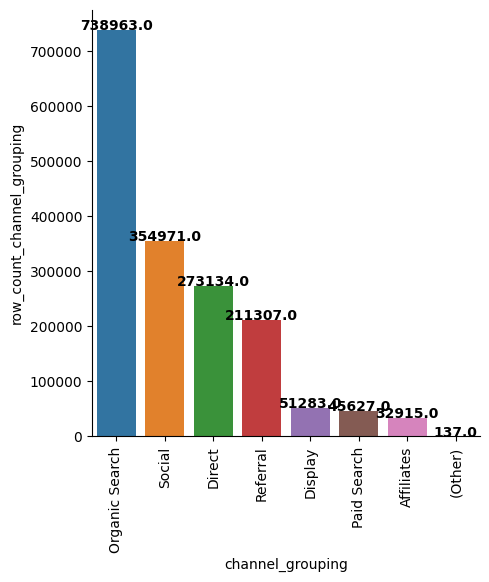

In [19]:
create_multiple_plots(df=channel_df, x='channel_grouping', y='row_count_channel_grouping', kind='bar', orientation='v')

- Most common channel_grouping is Organic Search. It will be nice to see how it changes fir a person.

### 1.2 How many unique channel_grouping values are associated with a user identified by full_visitor_id

In [20]:
unique_channel_grouping_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [21]:
unique_channel_grouping_per_user_df['unique_count_channel_grouping'].value_counts()

unique_count_channel_grouping
1    1291102
2      36018
3       2190
4        111
5         12
6          1
Name: count, dtype: int64

- This shows that majority of visitors (1291102) use only 1 unique channel_grouping. Only 1 person uses 6 channel groupings.

### 1.3 What are the comma separated unique channel_grouping values associated with each full_visitor_id

In [22]:
#res_df = con.execute(f"select full_visitor_id, STRING_AGG(DISTINCT(channel_grouping), ',') AS concatenated_unique_channel_grouping from intermediate_train_data group by full_visitor_id").df()
unique_channel_grouping_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [23]:
merged_unique_channel_grouping_string_df = pd.merge(unique_channel_grouping_string_df, unique_channel_grouping_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [24]:
merged_unique_channel_grouping_string_df[merged_unique_channel_grouping_string_df.unique_count_channel_grouping == 1]['concatenated_unique_channel_grouping'].value_counts()

concatenated_unique_channel_grouping
Organic Search    576201
Social            325886
Direct            195091
Referral          112865
Display            32352
Paid Search        25331
Affiliates         23347
(Other)               29
Name: count, dtype: int64

- Clearly, Organic Search is the most common channel via which users arrive at the GStore for the users who have one unique channel_grouping associated with them

### 2. Analyse social_engagement_type column [REMOVE THIS COLUMN]

In [25]:
social_engagement_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='social_engagement_type', group_by_column_list=['social_engagement_type'])

In [26]:
social_engagement_df

,social_engagement_type,row_count_social_engagement_type
0,Not Socially Engaged,1708337


- Clearly all the rows have common value Not Socially Engaged. Delete this column

### 3. Analyze visit_number column (An identifier for this session. It is unique for a visitor. It can help to understand how many sessions a given visitor was involved in)

### 3.1 How many unique visit_number values are associated with a user identified by full_visitor_id

In [27]:
unique_visit_number_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='visit_number', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [28]:
unique_visit_number_per_user_df.head()

,full_visitor_id,unique_count_visit_number
0,1957458976293878100,400
1,7282998257608986241,315
2,3884810646891698298,268
3,7477638593794484792,218
4,824839726118485274,209


### 3.2 Quartile analysis of unique_count_visit_number

In [29]:
unique_visit_number_per_user_df.unique_count_visit_number.describe()

count    1.329434e+06
mean     1.281251e+00
std      1.520005e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+02
Name: unique_count_visit_number, dtype: float64

- It is clear from the graph that 75% of users have 1 session associated with them.  

## 4. Analyse visit_start_time (The timestamp (expressed as POSIX time))

In [30]:
#con.execute("select TO_TIMESTAMP(visit_start_time) AS utc_visit_start_time, visit_start_time, date, geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_city, totals_transactions	 from intermediate_train_data").df()

In [31]:
con.execute("select utc_visit_start_time, visit_start_time, date, geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_city, totals_transactions	 from intermediate_train_data").df()

,utc_visit_start_time,visit_start_time,date,geo_network_continent,geo_network_sub_continent,geo_network_country,geo_network_region,geo_network_city,totals_transactions
0,2017-12-13 00:29:50,1513124990,20171212,Americas,Northern America,United States,North Carolina,Charlotte,NaN
1,2017-12-13 00:30:20,1513125020,20171212,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,NaN
2,2017-12-13 00:31:32,1513125092,20171212,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,NaN
3,2017-12-13 01:08:18,1513127298,20171212,Americas,Northern America,United States,New York,New York,NaN
4,2017-12-13 00:29:20,1513124960,20171212,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,NaN
...,...,...,...,...,...,...,...,...,...
1708332,2017-08-14 07:05:21,1502694321,20170814,Asia,Southeast Asia,Vietnam,Ho Chi Minh City,Ho Chi Minh City,NaN
1708333,2017-08-15 02:57:13,1502765833,20170814,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,NaN
1708334,2017-08-14 15:22:48,1502724168,20170814,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,NaN
1708335,2017-08-14 07:38:59,1502696339,20170814,Asia,Southeast Asia,Vietnam,not available in demo dataset,not available in demo dataset,NaN


## 5. Analyze geo_network_continent

### 5.1 How many rows have a given geo_network_continent value associated with them?

In [32]:
geo_network_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['geo_network_continent'])

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


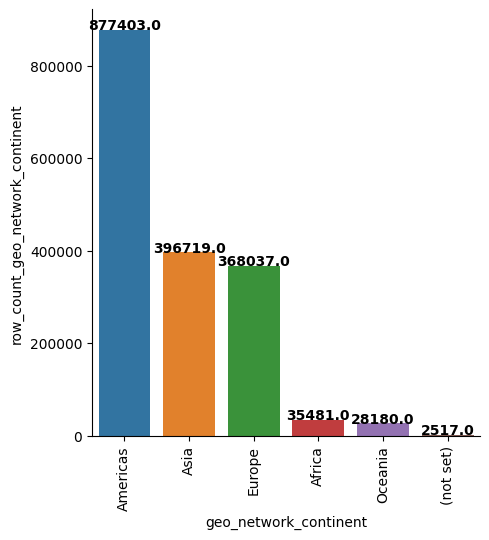

In [33]:
create_multiple_plots(df=geo_network_continent_df, x='geo_network_continent', y='row_count_geo_network_continent', kind='bar', orientation='v')

- Clearly majority if visits are from Americas

### 5.2 How many unique geo_network_continent values are associated with a user identified by full_visitor_id

In [34]:
unique_geo_network_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [35]:
unique_geo_network_continent_per_user_df.unique_count_geo_network_continent.value_counts()

unique_count_geo_network_continent
1    1326922
2       2460
3         50
4          2
Name: count, dtype: int64

- This shows that majority of full_visitor_id are associated with only one continent. However, there are certain  full_visitor_id that are associated with multiple unique geo_network_continent values
- This implies that we cannot assume that full_visitor_id is linked to only one continent.

### 5.3 What are the comma separated unique geo_network_continent values associated with each full_visitor_id?

In [36]:
unique_geo_network_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [37]:
merged_unique_geo_network_continent_string_df = pd.merge(unique_geo_network_continent_string_df, unique_geo_network_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [38]:
merged_unique_geo_network_continent_string_df[merged_unique_geo_network_continent_string_df.unique_count_geo_network_continent == 1]['concatenated_unique_geo_network_continent'].value_counts()

concatenated_unique_geo_network_continent
Americas     625354
Asia         337318
Europe       306088
Africa        32149
Oceania       23920
(not set)      2093
Name: count, dtype: int64

In [39]:
get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_name='unique_session_identifier', is_distinct_count=True, separator=',')['concatenated_unique_geo_network_continent'].value_counts()

concatenated_unique_geo_network_continent
Americas          876784
Asia              395977
Europe            367789
Africa             35461
Oceania            28140
(not set)           2514
(not set),Asia         1
Asia,Europe            1
Name: count, dtype: int64

## 6. Analyze geo_network_sub_continent

### 6.1 Get continent to subcontinent mapping 

In [40]:
continent_subcontinent_mapping_df = con.execute(f"select DISTINCT(geo_network_continent, geo_network_sub_continent) AS continent_dict from intermediate_train_data;").df()

In [41]:
continent_subcontinent_mapping_df.loc[:, ['geo_network_continent', 'geo_network_sub_continent']] = continent_subcontinent_mapping_df.apply(lambda row: row.continent_dict, axis='columns', result_type='expand')

In [42]:
geo_network_continent_sub_continent_mapping = dict(zip(continent_subcontinent_mapping_df.geo_network_sub_continent.values, continent_subcontinent_mapping_df.geo_network_continent.values))

### 6.2 How many rows have a given geo_network_sub_continent value associated with them?

In [43]:
geo_network_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_sub_continent'])

In [44]:
#geo_network_sub_continent_df['geo_network_continent'] = geo_network_sub_continent_df['geo_network_sub_continent'].map(geo_network_continent_sub_continent_mapping)

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


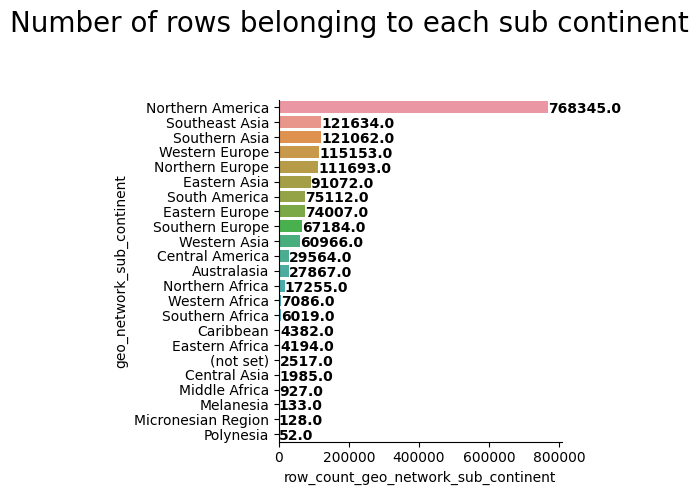

In [45]:
create_multiple_plots(df=geo_network_sub_continent_df, y='geo_network_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

### 6.3 How many rows have a given (geo_network_sub_continent, geo_network_sub_continent) value associated with them?

In [46]:
geo_network_continent_and_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent'], is_distinct_count=False)
#con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()

In [47]:
geo_network_continent_and_sub_continent_df['combine_continent_sub_continent'] = geo_network_continent_and_sub_continent_df['geo_network_continent'] + '_' + geo_network_continent_and_sub_continent_df['geo_network_sub_continent']

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


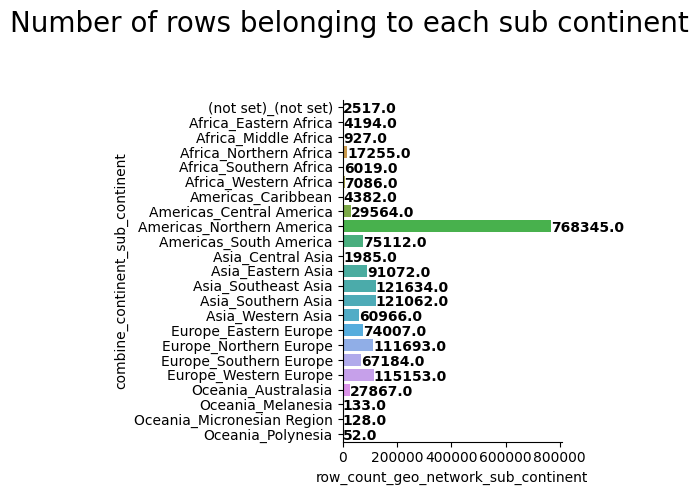

In [48]:
create_multiple_plots(df=geo_network_continent_and_sub_continent_df.sort_values(by=['combine_continent_sub_continent']), y='combine_continent_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

- It can be seen that Northern America has highest number of rows in the dataset

### 6.4 How many unique geo_network_sub_continent values are associated with a user identified by full_visitor_id

In [49]:
unique_geo_network_sub_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [50]:
unique_geo_network_sub_continent_per_user_df.unique_count_geo_network_sub_continent.value_counts()

unique_count_geo_network_sub_continent
1    1326063
2       3243
3        115
4         12
5          1
Name: count, dtype: int64

- Clearly, majority of people/ visitors are associated with 1 unique sub continenet. However, we see 1 person who has 5 unique sub continents

### 6.5 What are the comma separated unique geo_network_sub_continent values associated with each full_visitor_id?

In [51]:
unique_geo_network_sub_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [52]:
merged_unique_geo_network_sub_continent_string_df = pd.merge(unique_geo_network_sub_continent_string_df, unique_geo_network_sub_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [53]:
merged_unique_geo_network_sub_continent_string_df[merged_unique_geo_network_sub_continent_string_df.unique_count_geo_network_sub_continent == 1]['concatenated_unique_geo_network_sub_continent'].value_counts()

concatenated_unique_geo_network_sub_continent
Northern America      534042
Southeast Asia        106812
Southern Asia         104420
Western Europe         94711
Northern Europe        92476
Eastern Asia           71215
Eastern Europe         63736
South America          62919
Southern Europe        54791
Western Asia           52954
Central America        24389
Australasia            23640
Northern Africa        15551
Western Africa          6453
Southern Africa         5480
Eastern Africa          3774
Caribbean               3635
(not set)               2093
Central Asia            1804
Middle Africa            888
Melanesia                121
Micronesian Region       111
Polynesia                 48
Name: count, dtype: int64

- This shows that a lot of visitors who belong to exactly 1 geo_network_sub_continent are in Northern America

## 7. Analyze geo_network_country

### 7.1 How many rows have a given geo_network_country value associated with them?

In [54]:
geo_network_country_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_country', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent', 'geo_network_country'])

In [55]:
geo_network_country_df.head()

,geo_network_continent,geo_network_sub_continent,geo_network_country,row_count_geo_network_country
0,Americas,Northern America,United States,717217
1,Asia,Southern Asia,India,105317
2,Europe,Northern Europe,United Kingdom,73341
3,Americas,Northern America,Canada,51057
4,Europe,Western Europe,Germany,38516


In [56]:
row_count = geo_network_country_df['geo_network_continent'].nunique()
max_column_count = geo_network_country_df.groupby(by=['geo_network_continent']).agg({'geo_network_sub_continent':'nunique'})['geo_network_sub_continent'].max()

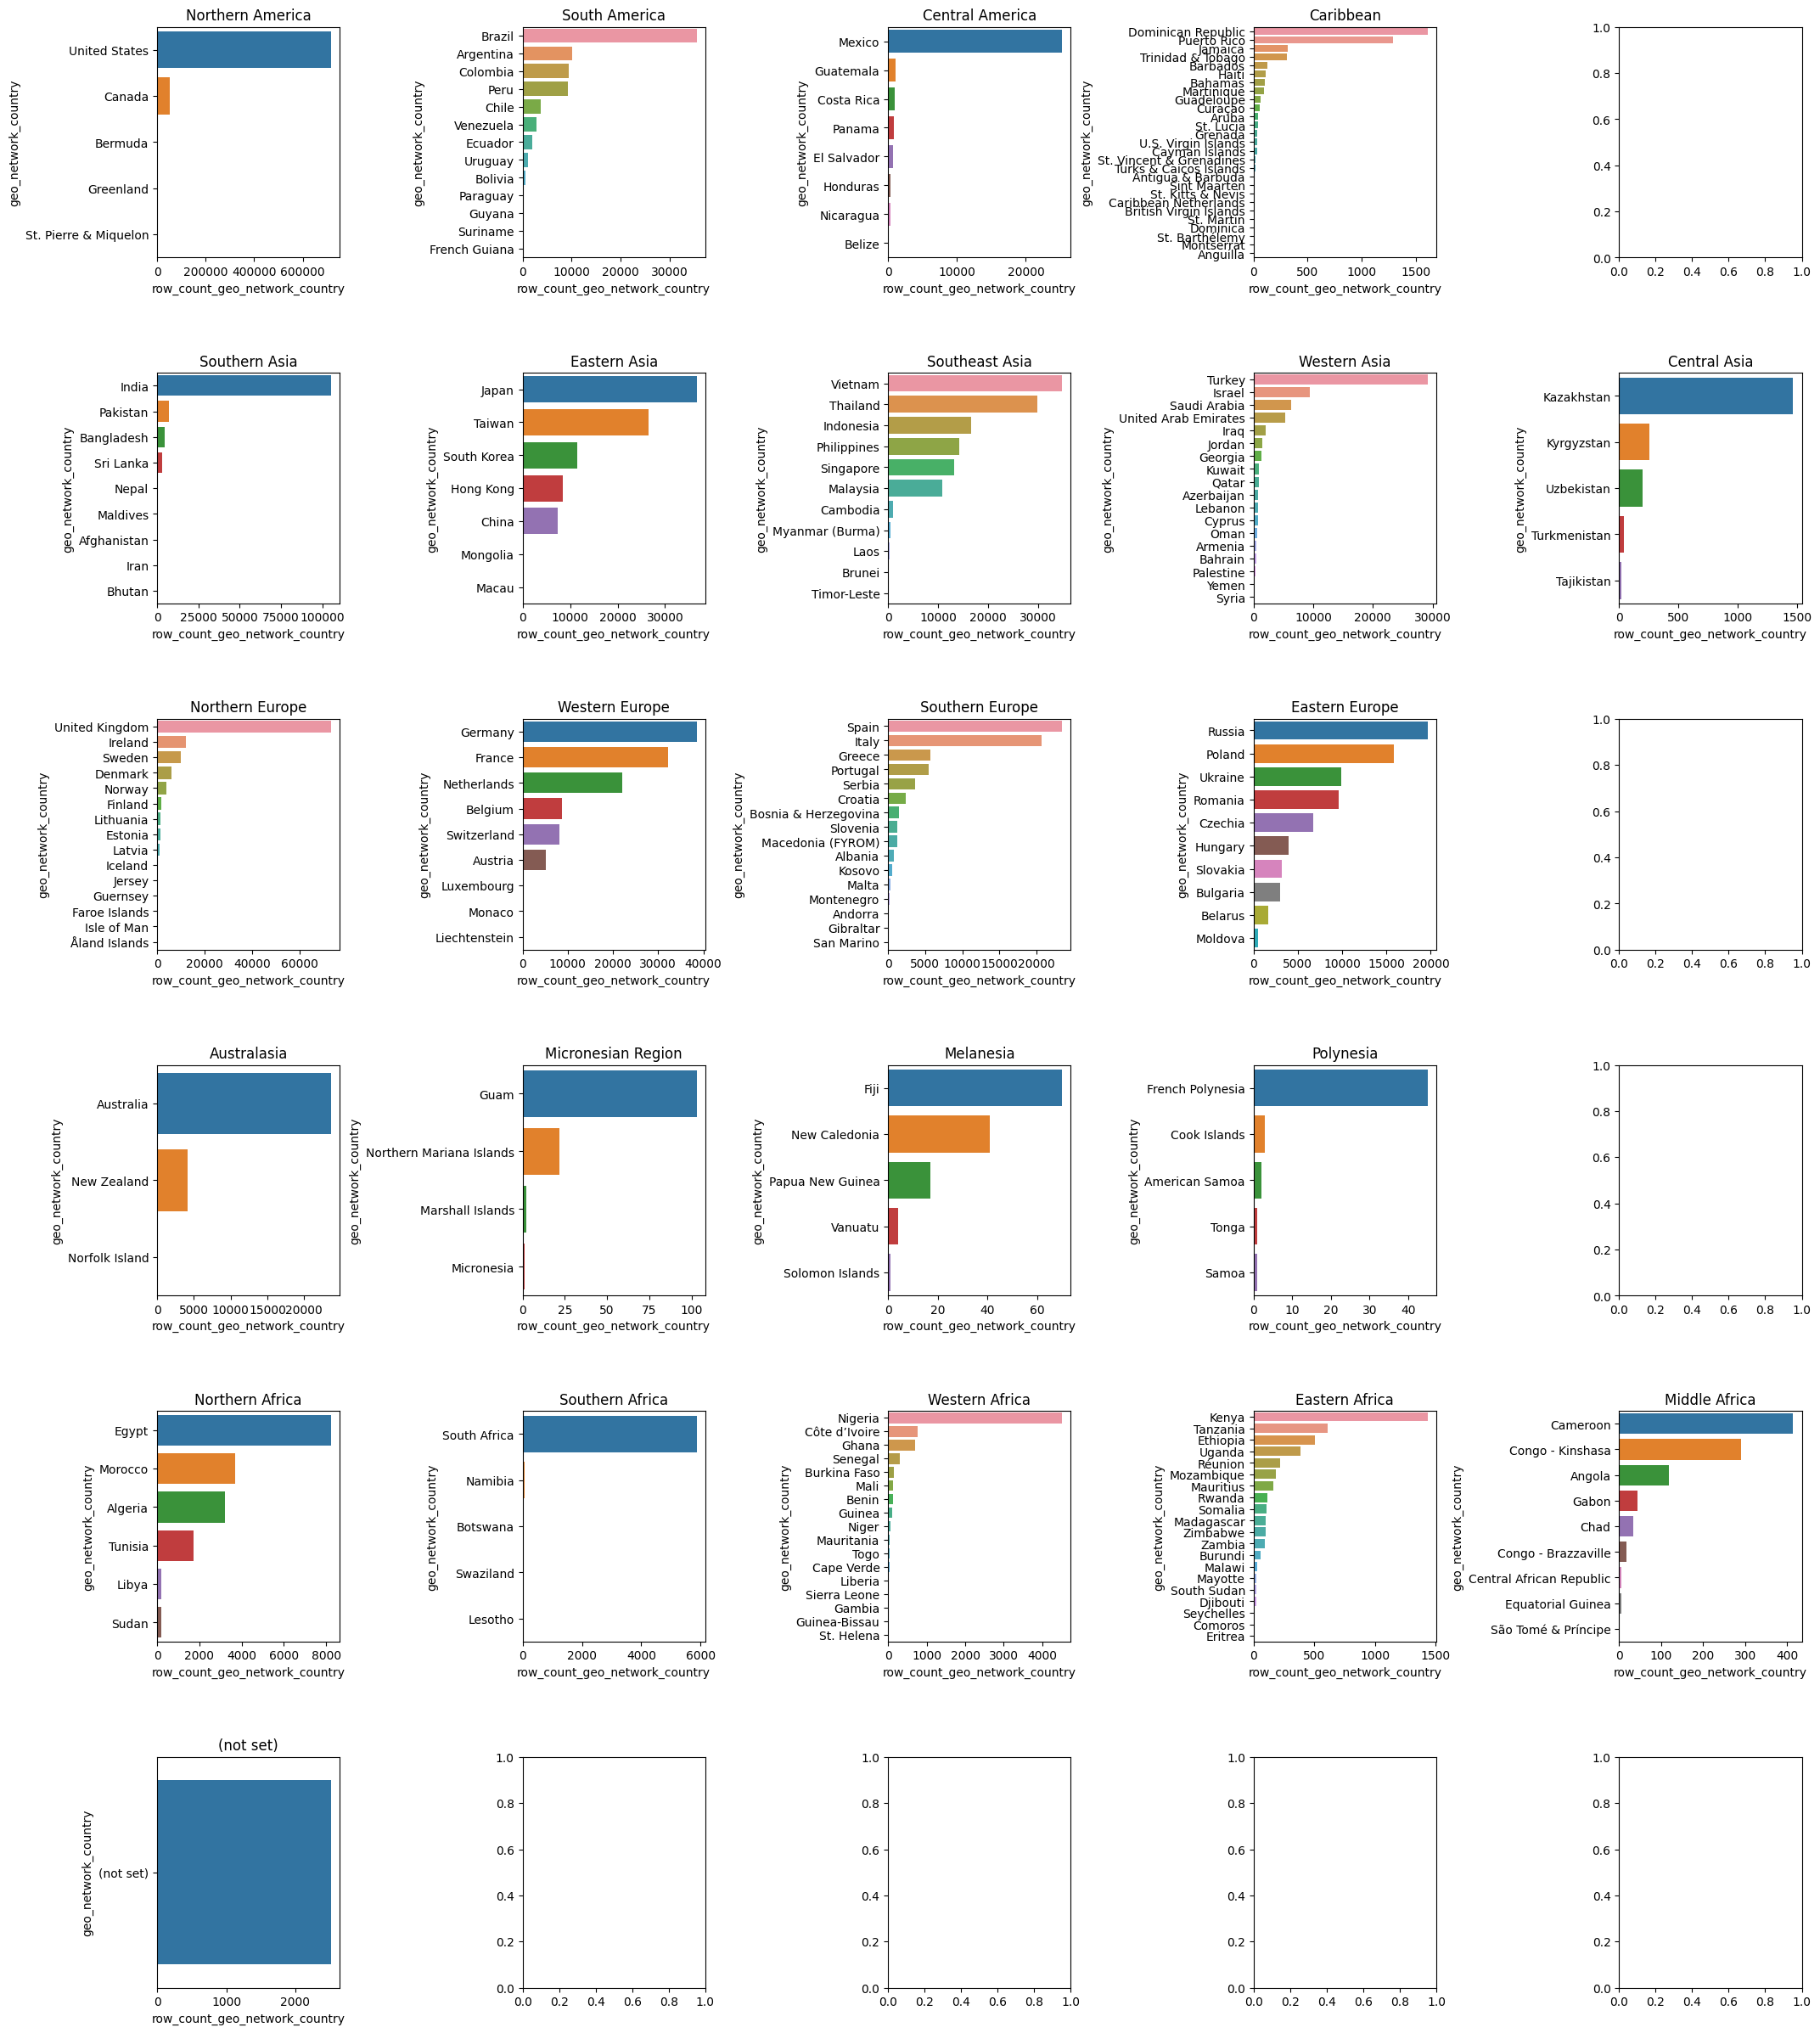

In [57]:
plot_graphs_by_looping(df=geo_network_country_df, row_identifier='geo_network_continent', column_identifier='geo_network_sub_continent', x_column_to_plot='row_count_geo_network_country', y_column_to_plot='geo_network_country', row_count=row_count, max_column_count=max_column_count)

- This graph shows number of rows belonging to each country in a given sub continent. Each row represents a continent

## 8. Analyze geo_network_region

In [58]:
geo_network_region_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_region', group_by_column_list=['geo_network_region'])

In [59]:
geo_network_region_df['percent_geo_network_region'] = geo_network_region_df['row_count_geo_network_region']/geo_network_region_df['row_count_geo_network_region'].sum()

In [60]:
geo_network_region_df.head()

,geo_network_region,row_count_geo_network_region,percent_geo_network_region
0,not available in demo dataset,932959,0.546121
1,California,206669,0.120977
2,(not set),49774,0.029136
3,New York,49733,0.029112
4,England,25824,0.015116


- 54% of rows do not have geo_network_region set. Hence delete this column

## 9. Analyze geo_network_metro

In [61]:
geo_network_metro_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_metro', group_by_column_list=['geo_network_metro'])

In [62]:
geo_network_metro_df['percent_geo_network_metro'] = geo_network_metro_df['row_count_geo_network_metro']/geo_network_metro_df['row_count_geo_network_metro'].sum()

In [63]:
geo_network_metro_df.head()

,geo_network_metro,row_count_geo_network_metro,percent_geo_network_metro
0,not available in demo dataset,932959,0.546121
1,(not set),386896,0.226475
2,San Francisco-Oakland-San Jose CA,182745,0.106972
3,New York NY,50419,0.029513
4,London,23643,0.013840


- Delete column geo_network_metro as 76% rows do not have thsis value.

## 10. Analyze geo_network_city/geo_network_city_id

In [64]:
geo_network_city_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_city', group_by_column_list=['geo_network_city'])

In [65]:
geo_network_city_df['percent_geo_network_city'] = geo_network_city_df['row_count_geo_network_city']/geo_network_city_df['row_count_geo_network_city'].sum()

In [66]:
geo_network_city_df

,geo_network_city,row_count_geo_network_city,percent_geo_network_city
0,not available in demo dataset,932959,0.546121
1,Mountain View,74110,0.043381
2,(not set),65867,0.038556
3,New York,49460,0.028952
4,San Francisco,36960,0.021635
...,...,...,...
951,North Creek,4,0.000002
952,Daly City,4,0.000002
953,Morgan Hill,4,0.000002
954,Boise,3,0.000002


- Delete column geo_network_city as 54% rows do not have this value.

## 11. Analyze geo_network_network_domain

In [67]:
geo_network_network_domain_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_domain', group_by_column_list=['geo_network_network_domain'])

In [128]:
geo_network_network_domain_df.head()

,geo_network_network_domain,row_count_geo_network_network_domain,domain
0,(not set),499049,NaN
1,unknown.unknown,269796,unknown
2,comcast.net,55486,net
3,rr.com,28715,com
4,verizon.net,26547,net


In [68]:
geo_network_network_domain_df['domain'] = geo_network_network_domain_df['geo_network_network_domain'].str.split('.').str[1]

- Delete column geo_network_network_domain

## 12. Analyze geo_network_latitude

In [69]:
get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_latitude', group_by_column_list=['geo_network_latitude'])

,geo_network_latitude,row_count_geo_network_latitude
0,not available in demo dataset,1708337


- Delete column geo_network_latitude

## 13. Analyze geo_network_longitude

In [70]:
get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_longitude', group_by_column_list=['geo_network_longitude'])

,geo_network_longitude,row_count_geo_network_longitude
0,not available in demo dataset,1708337


## 14. Analyze geo_network_network_location

In [71]:
geo_network_network_location_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_location', group_by_column_list=['geo_network_network_location'])

In [72]:
geo_network_network_location_df

,geo_network_network_location,row_count_geo_network_network_location
0,not available in demo dataset,1708337


## 15. Analyze device_browser
- Relevant device browser: chrome, safari, firefox, internet_explorer, (android_webview, android_browser, android_runtime), edge, samsung_internet, (opera_mini, opera, samsung-sm-b355e_opera), safari_(in-app), uc_browser, yabrowser, amazon_silk, coc_coc, (mozilla_compatible_agent, mozilla), mrchrome, maxthon, puffin, blackberry, nintendo_browser, (nokia_browser, nokiae52), iron, seamonkey, seznam, apple-iphone7c2, playstation_vita_browser, lunascape, konqueror, netscape, mqqbrowser, dillo

In [73]:
device_browser_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser', group_by_column_list=['device_browser'])

In [74]:
device_browser_df['normalized_device_browser'] = device_browser_df['device_browser'].str.lower().str.split(' ').str.join('_')

In [75]:
device_browser_df.head()

,device_browser,row_count_device_browser,normalized_device_browser
0,Chrome,1173056,chrome
1,Safari,312165,safari
2,Firefox,63845,firefox
3,Internet Explorer,35474,internet_explorer
4,Android Webview,34266,android_webview


## 16. Analyze device_browser_version

In [76]:
device_browser_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_version', group_by_column_list=['device_browser_version'])

In [77]:
device_browser_version_df

,device_browser_version,row_count_device_browser_version
0,not available in demo dataset,1708337


- Delete column device_browser_version

## 17. Analyze device_browser_size

In [78]:
device_browser_size_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_size', group_by_column_list=['device_browser_size'])

In [79]:
device_browser_size_df

,device_browser_size,row_count_device_browser_size
0,not available in demo dataset,1708337


## 18. Analyze device_operating_system

In [80]:
device_operating_system_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['device_operating_system'])

In [81]:
device_operating_system_df.head()

,device_operating_system,row_count_device_operating_system
0,Windows,619720
1,Macintosh,438514
2,Android,299386
3,iOS,219334
4,Linux,63971


### 18.1 How many unique device_operating_system values are associated with a given visitor?

In [82]:
unique_device_operating_system_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [83]:
unique_device_operating_system_per_user_df.unique_count_device_operating_system.value_counts()

unique_count_device_operating_system
1    1328918
2        512
3          3
4          1
Name: count, dtype: int64

- Majority of visitors use only one operating system. Very rarely does it go beyond 1

### 18.2 What are the comma separated unique device_operating_system values associated with each full_visitor_id?

In [84]:
unique_device_operating_system_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [85]:
merged_unique_device_operating_system_string_df = pd.merge(unique_device_operating_system_string_df, unique_device_operating_system_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [86]:
merged_unique_device_operating_system_string_df[merged_unique_device_operating_system_string_df.unique_count_device_operating_system.isin([3, 4])]

,full_visitor_id,concatenated_unique_device_operating_system,unique_count_device_operating_system
23429,9076460273340267611,"Android,Linux,Macintosh,Windows",4
86182,4078913419231868673,"Android,Macintosh,iOS",3
858049,5157367009031195155,"Android,Macintosh,iOS",3
1025915,1299148485081161968,"Android,Macintosh,iOS",3


## 19. Analyze device_operating_system_version

In [87]:
device_operating_system_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system_version', group_by_column_list=['device_operating_system_version'])

In [88]:
device_operating_system_version_df

,device_operating_system_version,row_count_device_operating_system_version
0,not available in demo dataset,1708337


- Delete device_operating_system_version column

## 20. Analyze device_is_mobile

In [89]:
device_is_mobile_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_is_mobile', group_by_column_list=['device_is_mobile'])

In [90]:
device_is_mobile_df

,device_is_mobile,row_count_device_is_mobile
0,False,1171670
1,True,536667


In [91]:
unique_device_operating_system_system_per_device_is_mobile_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='device_is_mobile', is_distinct_count=True, separator=',')

In [92]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[0]['concatenated_unique_device_operating_system']

'(not set),Android,Chrome OS,FreeBSD,Linux,Macintosh,Nintendo Wii,OS/2,OpenBSD,SunOS,Tizen,Windows,Xbox,iOS'

In [93]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[1]['concatenated_unique_device_operating_system']

'(not set),Android,BlackBerry,Firefox OS,Linux,Macintosh,NTT DoCoMo,Nintendo 3DS,Nintendo WiiU,Nokia,Playstation Vita,Samsung,SymbianOS,Tizen,Windows,Windows Phone,iOS'

## 21. Analyze device_mobile_device_branding

In [94]:
device_mobile_device_branding_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_branding', group_by_column_list=['device_mobile_device_branding'])

In [95]:
device_mobile_device_branding_df

,device_mobile_device_branding,row_count_device_mobile_device_branding
0,not available in demo dataset,1708337


## 22. Analyze device_mobile_device_model

In [96]:
device_mobile_device_model_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_model', group_by_column_list=['device_mobile_device_model'])

In [97]:
device_mobile_device_model_df

,device_mobile_device_model,row_count_device_mobile_device_model
0,not available in demo dataset,1708337


## 23. Analyze device_mobile_input_selector

In [98]:
device_mobile_input_selector_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_input_selector', group_by_column_list=['device_mobile_input_selector'])

In [99]:
device_mobile_input_selector_df

,device_mobile_input_selector,row_count_device_mobile_input_selector
0,not available in demo dataset,1708337


## 24. Analyze device_mobile_device_info

In [100]:
device_mobile_device_info_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_info', group_by_column_list=['device_mobile_device_info'])

In [101]:
device_mobile_device_info_df

,device_mobile_device_info,row_count_device_mobile_device_info
0,not available in demo dataset,1708337


## 25. Analyze device_mobile_device_marketing_name

In [102]:
device_mobile_device_marketing_name_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_marketing_name', group_by_column_list=['device_mobile_device_marketing_name'])

In [103]:
device_mobile_device_marketing_name_df

,device_mobile_device_marketing_name,row_count_device_mobile_device_marketing_name
0,not available in demo dataset,1708337


## 26. Analyze device_flash_version

In [104]:
device_flash_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_flash_version', group_by_column_list=['device_flash_version'])

In [105]:
device_flash_version_df

,device_flash_version,row_count_device_flash_version
0,not available in demo dataset,1708337


## 27. Analyze device_language

In [106]:
device_language_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_language', group_by_column_list=['device_language'])

In [107]:
device_language_df

,device_language,row_count_device_language
0,not available in demo dataset,1708337


## 28. Analyze device_screen_colors

In [108]:
device_screen_colors_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_colors', group_by_column_list=['device_screen_colors'])

In [109]:
device_screen_colors_df

,device_screen_colors,row_count_device_screen_colors
0,not available in demo dataset,1708337


## 29. Analyze device_screen_resolution

In [110]:
device_screen_resolution_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_resolution', group_by_column_list=['device_screen_resolution'])

In [111]:
device_screen_resolution_df

,device_screen_resolution,row_count_device_screen_resolution
0,not available in demo dataset,1708337


## 30. Analyze device_device_category

In [112]:
device_device_category_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['device_device_category'])

In [113]:
device_device_category_df

,device_device_category,row_count_device_device_category
0,desktop,1171579
1,mobile,471336
2,tablet,65422


### 30.1 How many unique device_device_category values are associated with a user identified by full_visitor_id

In [114]:
unique_device_device_category_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [115]:
unique_device_device_category_per_user_df.unique_count_device_device_category.value_counts()

unique_count_device_device_category
1    1329434
Name: count, dtype: int64

- Very interseting to see that every visitor uses only 1 unique device_device_category

## 25. Analyze totals - This section contains aggregate values across the session [TODO AGAIN CORRECTLY]
- https://www.digishuffle.com/blogs/google-analytics-sessions-hits-metric-simplified/
- https://themeisle.com/blog/page-views-vs-visits/#gref

Session: A session is the total time a user spends on your website within a certain period. A session typically expires after 30 minutes of inactivity. A session is a group of user interactions with your website that take place within a given time frame

Note: Contrary to popular belief, high page views don’t always mean you’re reaching a broad audience. High page visits are generally positive, as they indicate that your website is popular.

### 25.0 Analyze visit_id, unique_session_identifier
-  How many unique visit_id values are associated with a user identified by full_visitor_id

In [ ]:
unique_visit_id_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='visit_id', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
unique_visit_id_per_user_df.head()

In [ ]:
unique_session_identifier_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='unique_session_identifier', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [ ]:
#merged_session_df = unique_visit_number_per_user_df.merge(unique_visit_id_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='inner')
merged_session_df = unique_visit_id_per_user_df.merge(unique_session_identifier_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='inner')

In [ ]:
merged_session_df.head()

<b> unique_session_identifier(full_visitor_id, visit_id) combo correctly identifies the session a user is involved in </b><br/>
<b> To get number of unique sessions a full_visitor_id (user) is involved in, count number of unique unique_session_identifier or visit_id values</b>

## Distribution of number of sessions a unique visitor is involved in

In [ ]:
sns.boxplot(data=merged_session_df, x='unique_count_unique_session_identifier')

In [ ]:
merged_session_df['unique_count_unique_session_identifier'].describe()

<b>Majority(>75%) of people are involved in 1 session.</b>

### 25.0.1 Analyze how many rows are associated with a given unique_session_identifier/ session

In [ ]:
rows_for_unique_session_identifier_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='unique_session_identifier', group_by_column_list=['unique_session_identifier'])

In [ ]:
rows_for_unique_session_identifier_df.head()

In [ ]:
rows_for_unique_session_identifier_df.row_count_unique_session_identifier.value_counts(normalize=True)

<b>99.9% of sessions have exactly 1 row associated with them. Remaining have 2 rows associated with them. So in the data that we have, a session can span a max of 2 rows</b>

In [ ]:
rows_for_unique_session_identifier_df[rows_for_unique_session_identifier_df.row_count_unique_session_identifier == 2].tail()

In [ ]:
column_name_list = [col[0] for col in con.execute(f"SELECT * FROM intermediate_train_data LIMIT 0").description]

In [ ]:
totals_column_list = [col for col in column_name_list if 'totals_' in col]

In [ ]:
totals_column_list

In [ ]:
con.execute(f"""select visit_start_time, traffic_source_source, {','.join(totals_column_list)} from intermediate_train_data where unique_session_identifier = '7211158502445215770_1499841487'""").df()

In [ ]:
con.execute(f"select unique_session_identifier,  SUM(CAST(totals_visits AS DOUBLE)) AS totals_visits, SUM(CAST(totals_hits AS DOUBLE)) AS totals_hits from intermediate_train_data where unique_session_identifier='7211158502445215770_1499841487' group by unique_session_identifier ").df().head()

In [ ]:
con.execute(f"describe select * from intermediate_train_data").df()

### 25.1 totals_visits
- Page Visit: A page visit happens whenever someone reaches your site from an external source, outside of your website’s domain. For instance, if a user finds your article online and then reloads the page, that still counts as one visit. However, if they navigate away from your website, search for a new keyword in Google, and then land on your page again, this will count as two visits


In [130]:
def get_aggregates_for_numerical_variable_using_groupby_column(con, table_name, numeric_column_name, analysis_type='session'):
    # if isinstance(group_by_column_list, list):
    #     group_by_column_name = ','.join(group_by_column_list)
    if analysis_type == 'session':
        ## Step 1: Get session level data
        session_df_query = f"select full_visitor_id, unique_session_identifier, SUM(CAST({numeric_column_name} AS DOUBLE)) AS {numeric_column_name} from {table_name} GROUP BY full_visitor_id, unique_session_identifier"
        return con.execute(f"select full_visitor_id, min({numeric_column_name}) AS min_{numeric_column_name}_per_session, max({numeric_column_name}) AS max_{numeric_column_name}_per_session, SUM({numeric_column_name}) AS sum_{numeric_column_name}, AVG(COALESCE({numeric_column_name}, 0)) AS avg_{numeric_column_name}_per_session, median({numeric_column_name}) AS median_{numeric_column_name}_per_session, COUNT(unique_session_identifier) AS session_count from {table_name} group by full_visitor_id;").df()
    # elif analysis_type == 'store_visit':
    #     return con.execute(f"select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, SUM(CAST({numeric_column_name} AS DOUBLE)) AS sum_{numeric_column_name}, AVG(COALESCE(CAST({numeric_column_name} AS DOUBLE), 0)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(visit_number) AS session_count from {table_name} group by {group_by_column_name};").df()

In [ ]:
## select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, SUM(CAST({numeric_column_name} AS DOUBLE)) AS sum_{numeric_column_name}, AVG(COALESCE(CAST({numeric_column_name} AS DOUBLE), 0)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(visit_number) AS session_count from {table_name} group by {group_by_column_name};
totals_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_visits', ['full_visitor_id'])

In [ ]:
totals_visits_per_user_aggregates_df[totals_visits_per_user_aggregates_df.session_count > 300]

- This shows that each visitor/full_visitor_id has exactly 1 visit per session. Even the visitor having 400 sessions, has maximum of 1 visit across each of 400 sessions.
- Possible features:
1. Before a date, how many visits per session have been made?
2. Before a date, total number of visits?
3. Before a date, min, max, avg, median visits per session?

In [ ]:
kk = con.execute(f"select full_visitor_id, AVG(totals_visits) AS avg_totals_visits_per_session from (select full_visitor_id, unique_session_identifier, sum(CAST(totals_visits AS DOUBLE)) AS totals_visits from intermediate_train_data group by full_visitor_id, unique_session_identifier) group by full_visitor_id;").df()

In [ ]:
kk.avg_totals_visits_per_session.value_counts()

In [ ]:
kk_agg = kk.groupby(by=['full_visitor_id']).agg(avg_totals_visits_per_session=pd.NamedAgg(column="totals_visits", aggfunc="mean"))

In [ ]:
kk_agg.avg_totals_visits_per_session.value_counts()

In [ ]:
kk_agg

### 25.2 totals_pageviews [Type of interaction hit]
- Page View: A page view occurs whenever someone loads your site in their web browser (not necessary to be from external source). A view is registered every time a page is loaded. 

In [ ]:
totals_pageviews_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_pageviews', ['full_visitor_id'])

In [ ]:
totals_pageviews_per_user_aggregates_df.loc[:, 'session_type'] = 'single'
totals_pageviews_per_user_aggregates_df.loc[totals_pageviews_per_user_aggregates_df.session_count>1, 'session_type'] = 'multiple'

In [ ]:
totals_pageviews_per_user_aggregates_df.head()

In [ ]:
totals_pageviews_per_user_aggregates_df[totals_pageviews_per_user_aggregates_df.session_count>300]

In [ ]:
totals_pageviews_per_user_aggregates_df[totals_pageviews_per_user_aggregates_df.avg_totals_pageviews_per_session>400]

In [ ]:
create_multiple_plots(df=totals_pageviews_per_user_aggregates_df, x='avg_totals_pageviews_per_session', y='session_type', kind='box', title='Each point represents one visitor/ visitor_id')

- Avg number of page views per session goes from 1 all the way to >400 page views per session. This might be a good indicator of the interest of the visitor and chances to convert

In [ ]:
sns.scatterplot(data=totals_pageviews_per_user_aggregates_df, x="session_count", y="avg_totals_pageviews_per_session")

- Clearly, session_count (of a visitor) is not correlated avg_totals_pageviews_per_session.
- Some people with 1 session have >400 views per session on average. This indicates string interest (possibly higher chances of converting).
- On the other hand people who visit the site across many sessions(e.g. 400) how lower avg_totals_pageviews_per_session. This implies that they may just visit the site to browse and look for options. 

### 25.3 totals_hits [Interaction + non interaction hits = Screenview hit, PageView Hit, Event Hit, Exception Hit, Ecommerce Hit, Social INteraction Hit, User Timing Hit]
- A Hit is an interaction that results in data being sent to Analytics. 2 types: Interaction and non interaction hits

In [ ]:
totals_hits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_hits', ['full_visitor_id'])

In [ ]:
totals_hits_per_user_aggregates_df.loc[:, 'session_type'] = 'single'
totals_hits_per_user_aggregates_df.loc[totals_hits_per_user_aggregates_df.session_count>1, 'session_type'] = 'multiple'

In [ ]:
totals_hits_per_user_aggregates_df[totals_hits_per_user_aggregates_df.session_count>300]

- Clearly, there are some people who have a large distribution of hits per session.

In [ ]:
res = con.execute("select CAST (totals_hits AS DOUBLE) AS totals_hits from intermediate_train_data where full_visitor_id = '7282998257608986241'").df()

In [ ]:
sns.histplot(data=res, x='totals_hits').set(title='Example distribution of totals_hits for full_visitor_id = 824839726118485274')

In [ ]:
create_multiple_plots(df=totals_hits_per_user_aggregates_df, x='avg_totals_hits_per_session', y='session_type', kind='box', title='Each point represents one visitor/ visitor_id')

## Scatterplot for avg total hits versus avg total page views

In [ ]:
merged_totals_pageviews_per_user_totals_hits_per_user_aggregates_df = totals_pageviews_per_user_aggregates_df.merge(totals_hits_per_user_aggregates_df, left_on='full_visitor_id', right_on='full_visitor_id', how='inner')

In [ ]:
sns.scatterplot(data=merged_totals_pageviews_per_user_totals_hits_per_user_aggregates_df, x="avg_totals_pageviews_per_session", y="avg_totals_hits_per_session")

- It is clear that avg_totals_pageviews_per_session is positively correlated with avg_totals_hits_per_session. This makes sense as pageviews is a type of hit. This means higher the number of page views => higher the number of hits

### 25.4 totals_time_on_site

In [131]:
totals_time_on_site_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_time_on_site', ['full_visitor_id'])

In [132]:
totals_time_on_site_per_user_aggregates_df

- This column is not recorded for majority of rows. Hence drop it

### 25.4 totals_new_visits

In [ ]:
totals_new_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_new_visits', ['full_visitor_id'])

- Drop totals_new_visits column

### 25.5 totals_session_quality_dim -> Drop column

### 25.6 totals_bounces

In [ ]:
totals_bounces_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_bounces', ['full_visitor_id'])

In [ ]:
totals_bounces_per_user_aggregates_df.head()

### 25.7 totals_transactions

In [ ]:
totals_transactions_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_transactions', ['full_visitor_id'])

In [ ]:
totals_transactions_per_user_aggregates_df[~totals_transactions_per_user_aggregates_df['min_totals_transactions_per_session'].isnull()].sort_values(by=['session_count'], ascending=False).head()

In [ ]:
#con.execute("select CAST (totals_transactions AS DOUBLE) AS totals_transactions from intermediate_train_data where full_visitor_id = '3269834865385146569'").df()

### 25.8 totals_transaction_revenue

In [ ]:
totals_transaction_revenue_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_transaction_revenue', ['full_visitor_id'])

In [ ]:
totals_transaction_revenue_per_user_aggregates_df.head()

In [ ]:
totals_transaction_revenue_per_user_aggregates_df.min_totals_transaction_revenue_per_session.isnull().value_counts(normalize=True)

- Only 1.2% of visitors ever make a transaction. Remaining 98.7% never make a transaction across all their sessions

### 25.9 totals_total_transaction_revenue

In [ ]:
totals_total_transaction_revenue_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_total_transaction_revenue', ['full_visitor_id'])

In [ ]:
totals_total_transaction_revenue_per_user_aggregates_df

In [ ]:
scatter_data = con.execute("select CAST(totals_transaction_revenue AS DOUBLE) AS totals_transaction_revenue, CAST(totals_total_transaction_revenue AS DOUBLE) AS totals_total_transaction_revenue from intermediate_train_data").df()

In [ ]:
sns.scatterplot(data=scatter_data, x="totals_transaction_revenue", y="totals_total_transaction_revenue")

- Clearly, totals_total_transaction_revenue is correlated with totals_transaction_revenue

## 26. Analyze traffic_source related columns  (https://social.colostate.edu/best-practices/understanding-traffic-source-and-medium-in-google-analytics/, https://www.ceralytics.com/google-analytics-channels/#:~:text=The%20channel%20of%20%E2%80%9Cdisplay%E2%80%9D%20would,is%20used%20in%20display%20advertising.))

1. <b>traffic_source_source</b>: Source is the origin of your website traffic. It is the actual domain name (website/ platform) that sends traffic to my website
2. <b>traffic_source_medium</b>: It is the category of traffic source. Basically how the traffic gets to my site????
   - organic: Traffic from search engine results page coming to my website
   - social: Traffic from social media websites coming to my website
   - referral: Traffic coming from other websites that have links to my website. Referral programs are normally used to get your customers to refer other customers to your service in exchange of a perk, bonus or some sort of benefit. A popular example is what dropbox did, as they were giving extra storage to users referring new users
   - email: Traffic coming via email campaigns to my website
   - cpc: Cost per click, Traffic originates from clicks on ads that I am running for my business (and reaches my website)
   - cpm: CPM stands for cost per mille, which means the cost of reaching 1,000 people with an ad. Paid advertising option where companies pay a price for every 1000 impressions an ad receives (https://sproutsocial.com/glossary/cpm/)
   - affiliate: Affiliate programs are used by product owners to financially reward publishers in exchange of referring new customers. Affiliates are not necessarily customers of the actual product/service. https://support.google.com/analytics/thread/21925739/what-is-the-difference-between-affiliate-and-referral-traffic?hl=en
   - Direct: Traffic is entirely composed of people who are familiar you’re your brand and know your website. This is the fallback source bucket if traffic does not fall in any of above mentioned categories.
3. <b>traffic_source_campaign</b>
4. Channel: It is a group of traffic mediums as defined in https://support.google.com/analytics/answer/3297892?hl=en

### 26.1 Analyze traffic_source_source

In [116]:
traffic_source_source_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='traffic_source_source', group_by_column_list=['traffic_source_source'])

In [117]:
traffic_source_source_df

,traffic_source_source,row_count_traffic_source_source
0,google,658384
1,(direct),565975
2,youtube.com,329450
3,analytics.google.com,37436
4,Partners,32931
...,...,...
340,tumblr.com,1
341,voice.google.com,1
342,s7-eu4.ixquick.com,1
343,images.google.pt,1


- We can possibly use embeddings for traffic_source_source. Not sure how to use it

### 26.2 Analyze traffic_source_medium

In [118]:
traffic_source_medium_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='traffic_source_medium', group_by_column_list=['traffic_source_medium'])

In [119]:
traffic_source_medium_df

,traffic_source_medium,row_count_traffic_source_medium
0,organic,591783
1,(none),565957
2,referral,432963
3,cpc,75603
4,affiliate,32915
5,cpm,8982
6,(not set),134


In [120]:
get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='traffic_source_source', group_by_column_name='traffic_source_medium', is_distinct_count=True, separator=',')

,traffic_source_medium,concatenated_unique_traffic_source_source
0,(none),(direct)
1,referral,"9to5google.com,ad.doubleclick.net,admin.global..."
2,organic,"aol,ask,baidu,bing,centrum.cz,go.mail.ru,googl..."
3,cpm,"(direct),dfa,google"
4,affiliate,"(not set),Partners"
5,cpc,"bing,google"
6,(not set),"(not set),Partners,facebook.com,google,yahoo"


### 26.3 Analyze traffic_source_campaign

In [121]:
traffic_source_campaign_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='traffic_source_campaign', group_by_column_list=['traffic_source_campaign'])

In [122]:
traffic_source_campaign_df.iloc[2]['traffic_source_campaign']

'1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS'

In [126]:
get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='traffic_source_adwords_click_info_is_video_ad', group_by_column_list=['traffic_source_adwords_click_info_is_video_ad'])

,traffic_source_adwords_click_info_is_video_ad,row_count_traffic_source_adwords_click_info_is_video_ad
0,NaN,1633063
1,False,75274


In [127]:
intermediate_data_table.columns

['channel_grouping',
 'date',
 'full_visitor_id',
 'social_engagement_type',
 'visit_id',
 'visit_number',
 'visit_start_time',
 'device_browser',
 'device_browser_version',
 'device_browser_size',
 'device_operating_system',
 'device_operating_system_version',
 'device_is_mobile',
 'device_mobile_device_branding',
 'device_mobile_device_model',
 'device_mobile_input_selector',
 'device_mobile_device_info',
 'device_mobile_device_marketing_name',
 'device_flash_version',
 'device_language',
 'device_screen_colors',
 'device_screen_resolution',
 'device_device_category',
 'geo_network_continent',
 'geo_network_sub_continent',
 'geo_network_country',
 'geo_network_region',
 'geo_network_metro',
 'geo_network_city',
 'geo_network_city_id',
 'geo_network_network_domain',
 'geo_network_latitude',
 'geo_network_longitude',
 'geo_network_network_location',
 'traffic_source_campaign',
 'traffic_source_source',
 'traffic_source_medium',
 'traffic_source_is_true_direct',
 'traffic_source_adwords

## TODO:
1. Delete visit_number, social_engagement_type, geo_network_latitude, geo_network_longitude, geo_network_network_location, device_browser_version, device_browser_size, device_operating_system_version, device_mobile_device_branding, device_mobile_device_model, device_mobile_input_selector, device_mobile_device_info, device_mobile_device_marketing_name, device_flash_version, device_language, device_screen_colors, device_screen_resolution, totals_time_on_site, totals_new_visits, totals_session_quality_dim
2. Convert visit_start_time to date. Also try to map it to local time where the person was located wrt UTC
3. Column: geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_network_domain, device_operating_system, traffic_source_medium, traffic_source_source => Replace (not set) with 'unknown' AND reaplce (none) with 'not_applicable'
4. Set datatype to numeric: totals_visits
5. Use totals_transaction_revenue column to create GT labels

## Ideas:
1. Can get income level for visitor from geo_network_city.??
2. FEATURE: Number of transactions/session
3. Use embeddings for traffic_source_source. Not sure how to use it (https://github.com/dns-vsm/embeddings)

In [ ]:
con.execute("select date, count(*) from intermediate_train_data group by date limit 10;").df()

In [ ]:
con.execute("select utc_visit_start_time, count(*) from intermediate_train_data group by utc_visit_start_time;").df()

In [133]:
column_df = con.execute("select column_name, data_type from information_schema.columns where table_name='intermediate_train_data'").df()

In [136]:
column_df[column_df['column_name'] == 'traffic_source_campaign_code']

,column_name,data_type


In [ ]:
column_df